# 1. Data Processing

- Uploaded and extracted the GTSRB training dataset (43 labeled folders of .ppm images).
- Applied transforms: resized images to 32×32, converted to tensors, and normalized pixel values.
- Loaded the dataset using ImageFolder to structure images with correct class labels.
- Created a label mapping dictionary to associate class indices (0–42) with human-readable traffic sign names.
- Visualized the class distribution to identify imbalances in the training data

## 1.1 Load GTSRB Dataset


## 1.2 Resize Images

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
### Colab

data_dir = "data/GTSRB/Final_Training/Images"

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # resize all images to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


## 1.3 Structure the Dataset

In [13]:
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


## 1.4 Human-Readable Label Mapping

In [12]:
class_labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## 1.5 Visualize Class Distribution with ImageFolder

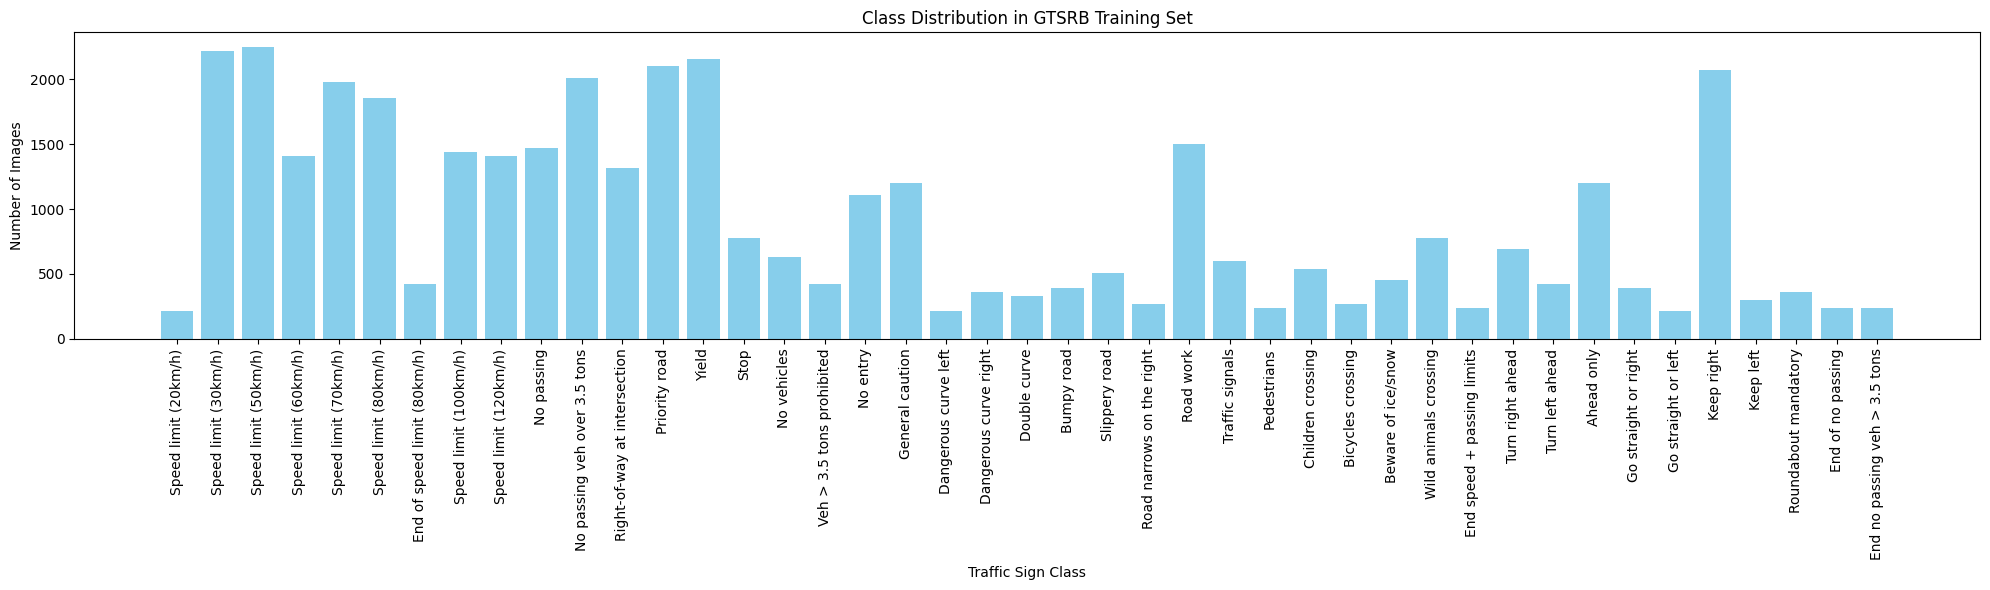

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Count labels from dataset
labels = [label for _, label in train_dataset]
label_counts = Counter(labels)

# Sort by label index
sorted_items = sorted(label_counts.items())
indices, counts = zip(*sorted_items)

# Map indices to human-readable labels
readable_labels = [class_labels[i] for i in indices]

# Plot
plt.figure(figsize=(20, 6))
plt.bar(readable_labels, counts, color='skyblue')
plt.xlabel("Traffic Sign Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution in GTSRB Training Set")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


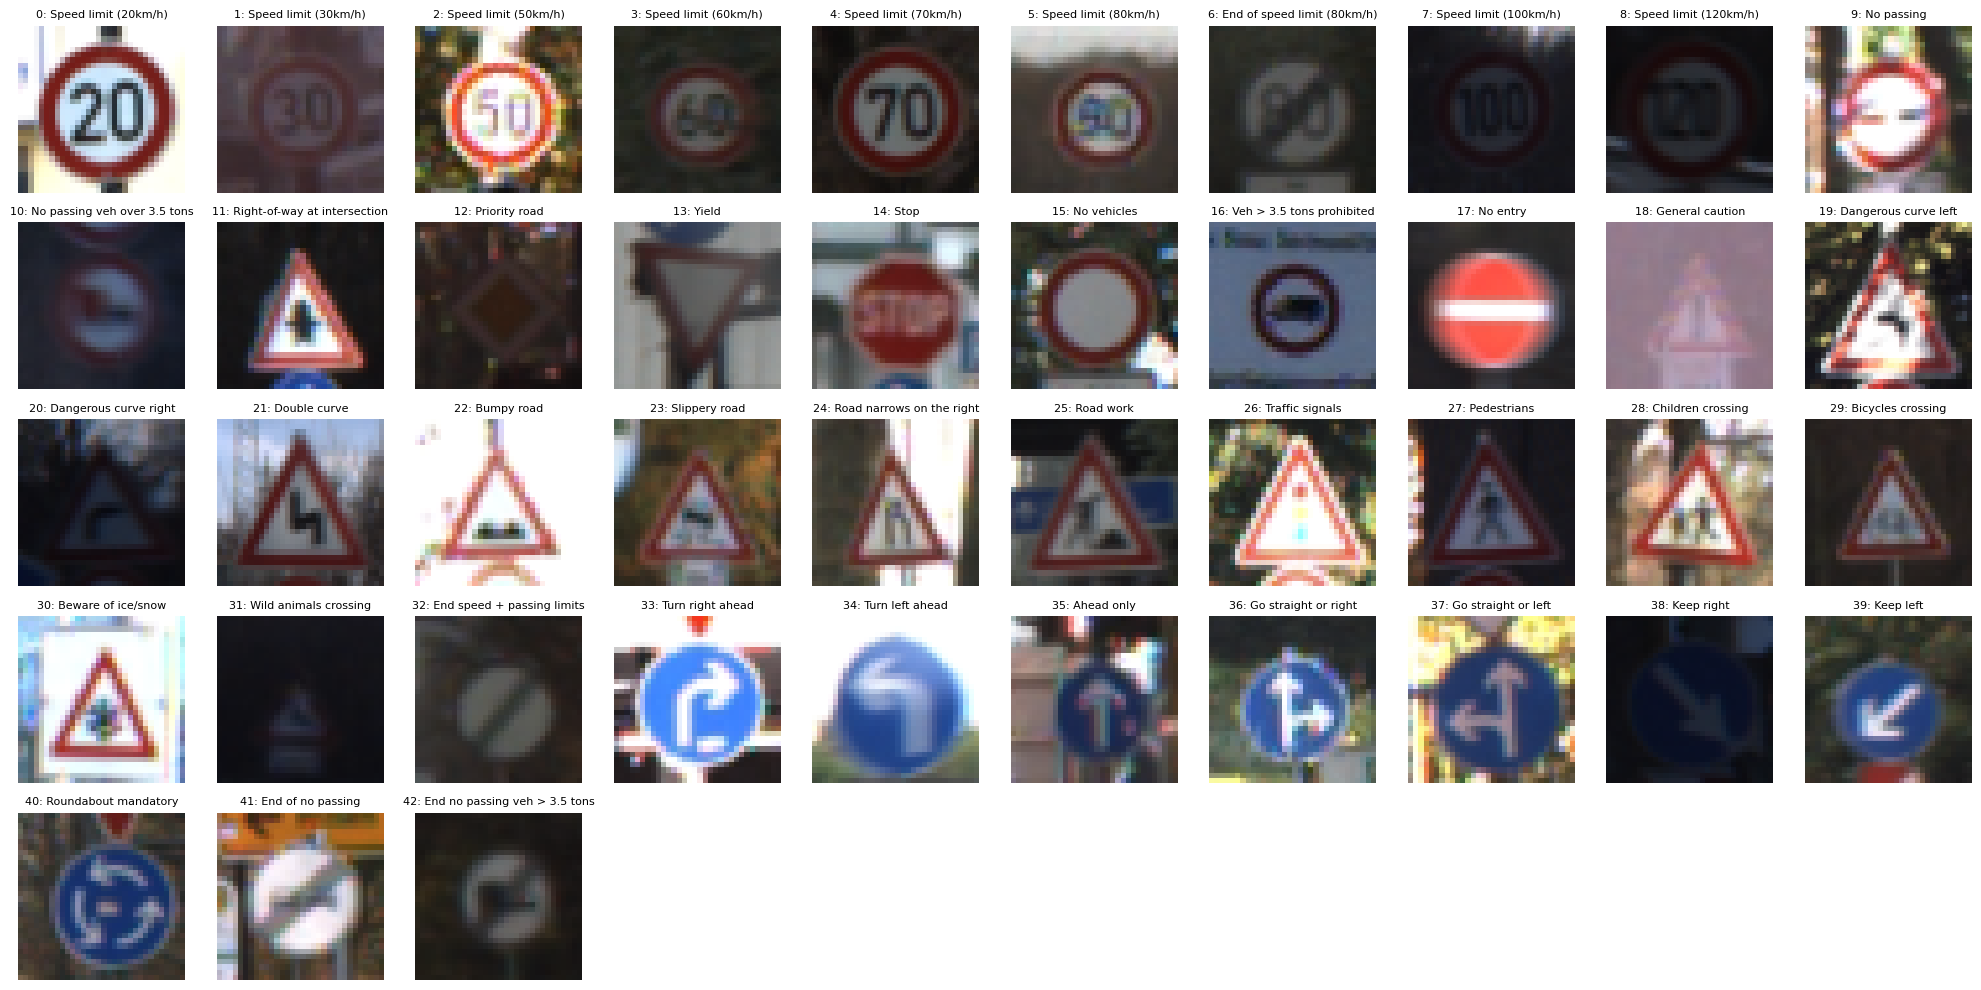

In [8]:
import random
import matplotlib.pyplot as plt
import math

def display_images_in_grid(dataset, class_labels, images_per_row=10):
    """
    Displays one random image from each class in a grid.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to sample from.
        class_labels (dict): A dictionary mapping class indices to human-readable labels.
        images_per_row (int): The number of images to display per row in the grid.
    """
    images_to_display = {}
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label not in images_to_display:
            images_to_display[label] = []
        images_to_display[label].append((image, label))

    # Collect one random image from each class
    selected_images = []
    sorted_classes = sorted(images_to_display.keys())
    for class_index in sorted_classes:
        class_images = images_to_display[class_index]
        random.shuffle(class_images)
        if class_images:
            selected_images.append(class_images[0])

    num_images = len(selected_images)
    num_rows = math.ceil(num_images / images_per_row)
    num_cols = images_per_row

    plt.figure(figsize=(2 * num_cols, 2 * num_rows)) # Adjust figure size as needed

    for i, (image_tensor, label) in enumerate(selected_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Convert tensor to numpy array and transpose dimensions for matplotlib
        image_np = image_tensor.permute(1, 2, 0).numpy()
        # Denormalize the image
        image_np = image_np * 0.5 + 0.5

        plt.imshow(image_np)
        plt.title(f"{label}: {class_labels[label]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display one random image from each class in a grid
display_images_in_grid(train_dataset, class_labels, images_per_row=10)

# 2. Dataset Manipulation

In [9]:
import torch
from torch.utils.data import random_split

# Define the split ratio (e.g., 80% for training, 20% for validation)
train_ratio = 0.8
validation_ratio = 1.0 - train_ratio

# Calculate the number of samples for each set
train_size = int(train_ratio * len(train_dataset))
validation_size = len(train_dataset) - train_size

# Use random_split to split the dataset
train_data, validation_data = random_split(
    train_dataset, [train_size, validation_size], generator=torch.Generator().manual_seed(42)
)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(validation_data)}")

Number of training samples: 31367
Number of validation samples: 7842


# 3. Baseline Model